# Pointwise mutual information (Взаимная точечная информация)
## Введение
**Немного информации о PMI:**
+ [Multinomial Naïve Bayes classifier using pointwise mutual information](https://towardsdatascience.com/multinomial-na%C3%AFve-bayes-classifier-using-pointwise-mutual-information-9ade011fcbd0)

+ [Understanding Pointwise Mutual Information in NLP](https://medium.com/dataseries/understanding-pointwise-mutual-information-in-nlp-e4ef75ecb57a)

+ [Harvesting the power of Mutual Information to find bias in your NLP dataset](https://towardsdatascience.com/harvesting-the-power-of-mutual-information-to-find-bias-in-your-nlp-dataset-c172c0dddebe)

+ [Learning NLP Language Models with Real Data](https://towardsdatascience.com/learning-nlp-language-models-with-real-data-cdff04c51c25)
  + [этот же пример в Kaggle](https://www.kaggle.com/code/osbornep/education-learning-language-models-with-real-data/notebook)

+ [Статья: A search engine model: Web Scraping, Natural Language Processing, and Pointwise Mutual Information](https://www.researchgate.net/publication/346088126_A_search_engine_model_Web_Scraping_Natural_Language_Processing_and_Pointwise_Mutual_Information)

+ [A Deep Conceptual Guide to Mutual Information](https://medium.com/swlh/a-deep-conceptual-guide-to-mutual-information-a5021031fad0)

+ [Word2Vec For Phrases — Learning Embeddings For More Than One Word](https://towardsdatascience.com/word2vec-for-phrases-learning-embeddings-for-more-than-one-word-727b6cf723cf)

**Определение:**
+ Измеряется между двумя случайными событиями A и B; 
+ Мера того, насколько сильно мы будем ожидать появление A после наблюдения события B, по сравнению с нашими ожиданиями в ситуации, когда событие B мы не наблюдаем;
+ PMI симметрична.

**Формула:**
$$PMI(A, B)=\log_{2}\frac{P(A, B)}{P(A)\cdot P(B)} = \log_{2}\frac{P(A|B)}{P(A)}= \log_{2}\frac{P(B|A)}{P(B)}$$

**Решаемые задачи:**
1. Поиск словосочетаний (наиболее частая встречаемость пар слов):
  + Глобальный поиск (найти самые частовстречаемые пары слов во всем корпусе);
  + Локальный поиск (по переданному слову определить наиболее связанные с ним слова);
2. Построение признакового пространства для задач классификации текста:
  + Отбор признаков ранжировав по PMI;
  + Построение эмбеддинга документов.



## Расчёт PMI
Пример подсчета PMI из Kaggle: https://www.kaggle.com/code/gabrielaltay/word-vectors-from-pmi-matrix

Рассмотрим вычисление PMI на примере задачи классификации. Для этого создаётся матрица с размерностью (число токенов, число классов). Значения матрицы - значения PMI.

$$PMI(w, c)=\log_{2}\frac{P(w, c)}{P(w)\cdot P(c)} = \log_{2}\frac{P(w|c)}{P(w)}= \log_{2}\frac{P(c|w)}{P(c)}$$

Где $w$ - слово, $с$ - класс.

Вероятность появлянения слова: $$P(w)=\frac{n_{w}}{n_{doc}}$$
Вероятность появлянения класса: $$P(с)=\frac{n_{с}}{n_{doc}}$$
Вероятность появлянения слова в конкретном классе: $$P(w|с)=\frac{n_{wс}}{n_{c}}$$
Вероятность совместного появления слова и класса: $$P(w, с)=\frac{n_{wс}}{n_{doc}}$$

$n_{w}$ - количество документов с конкретным словом;

$n_{с}$ - количество документов с конкретным классом;

$n_{wc}$ - количество документов с конкретным словом в конкретном классе;

$n_{doc}$ - общее количество документов в корпусе.

**Поправки в формулу PMI:**
+ Positive PMI (PPMI)
  + Для избежания PMI=-бесконечность
$$PPMI(w, c) = max(0, PMI(w, c))$$
+ Local mutual information (LMI) 
  + учитывает частоту токенов 
  + в частности орфографические ошибки
$$LMI(w, c) = P(w, с)\cdot PMI(w, c)$$

+ Normalized Pointwise Mutual Information (NPMI)
  + нормализует PMI между [-1,+1] : 
$$NPMI(w, c) = \frac{PMI(w, c)}{-\log_{2}P(w, с)}$$

**Алгоритм:**
1. Предобработка текста
2. Создание словаря слов
3. Расчет матрицы частотности размером (кол-во слов, кол-во классов)
4. Расчет матрицы PMI размером (кол-во слов, кол-во классов)
5. Создание матрицы признаков размером (кол-во примеров, кол-во слов)

# 1 Загрузка данных

In [1]:
# !pip install numpy pandas matplotlib seaborn scikit-learn nltk

In [2]:
%load_ext autoreload
%autoreload 2

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from nltk.corpus import stopwords

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.datasets import fetch_20newsgroups

from pmi.utils import plot_weights, print_minmax, print_nnz_sparse, text_tokenize, top_features
from pmi.collocation import PmiCollocation
from pmi.document import PmiDocument

from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

## 1.1 Пример из Wikipedia
https://en.wikipedia.org/wiki/Pointwise_mutual_information

In [3]:
TOTAL = 50_000_952  # всего слов

df_wiki = pd.read_csv('data/wiki_example.txt', sep='\t')
df_wiki.columns = [col.strip() for col in df_wiki.columns]
df_wiki

,word_1,word_2,count_word_1,count_word_2,count_of_co-occurrences,PMI
0,puerto,rico,1938,1311,1159,10.034908
1,hong,kong,2438,2694,2205,9.728320
2,los,angeles,3501,2808,2791,9.560676
3,carbon,dioxide,4265,1353,1032,9.098529
4,prize,laureate,5131,1676,1210,8.858707
5,san,francisco,5237,2477,1779,8.833052
6,nobel,prize,4098,5131,2498,8.689488
7,ice,hockey,5607,3002,1933,8.655576
8,star,trek,8264,1594,1489,8.639747
9,car,driver,5578,2749,1384,8.414708


In [4]:
p_w1 = df_wiki['count_word_1'] / TOTAL 
p_w2 = df_wiki['count_word_2'] / TOTAL
p_w1_w2 = df_wiki['count_of_co-occurrences'] / TOTAL
pmi = np.log(p_w1_w2 / (p_w1 * p_w2))
print('Равны ли PMI посчитанный и табличный:', np.isclose(pmi.values, df_wiki['PMI'].values).all())

Равны ли PMI посчитанный и табличный: True


## 1.2 Пример NLTK
https://www.listendata.com/2022/06/pointwise-mutual-information-pmi.html

In [5]:
text = "this is a foo bar bar black sheep  foo bar bar black sheep foo bar bar black sheep shep bar bar black sentence"
words = text.split()
bigram_measures = BigramAssocMeasures()
finder = BigramCollocationFinder.from_words(words)
pmi_nltk = []
for p in finder.score_ngrams(bigram_measures.pmi):
    pmi_nltk.append(p)
pmi_nltk 

[(('is', 'a'), 4.523561956057013),
 (('this', 'is'), 4.523561956057013),
 (('a', 'foo'), 2.938599455335857),
 (('sheep', 'shep'), 2.938599455335857),
 (('black', 'sentence'), 2.523561956057013),
 (('black', 'sheep'), 2.523561956057013),
 (('sheep', 'foo'), 2.353636954614701),
 (('bar', 'black'), 1.523561956057013),
 (('foo', 'bar'), 1.523561956057013),
 (('shep', 'bar'), 1.523561956057013),
 (('bar', 'bar'), 0.5235619560570131)]

## 1.3 Датасет "20 newsgroups" 
Далее в качестве данных используется датасет "20 newsgroups"

In [6]:
RS = 44
target_names = fetch_20newsgroups()['target_names']

X_train, y_train = fetch_20newsgroups(subset='train', return_X_y=True)
X_test, y_test = fetch_20newsgroups(subset='test', return_X_y=True)

print("Тренировочных документов:", len(X_train))
print("Тестовых документов:", len(X_test))
print("Классов:", len(np.unique(y_train)))

Тренировочных документов: 11314
Тестовых документов: 7532
Классов: 20


In [7]:
%%time
stopwords_set = set(stopwords.words('english'))

train_tokenized = text_tokenize(X_train, stopwords=stopwords_set)
test_tokenized = text_tokenize(X_test, stopwords=stopwords_set)
len(train_tokenized), len(test_tokenized)

CPU times: total: 6.36 s
Wall time: 6.59 s


(11314, 7532)

# 2 Поиск словосочетаний
## 2.1 Матрица PMI

In [8]:
%%time

colloc = PmiCollocation(min_words=5, window=2)
colloc.fit(train_tokenized)

matrix_pmi = colloc.matrix_pmi
matrix_lmi = colloc.matrix_lmi
matrix_npmi = colloc.matrix_npmi

print_minmax(matrix_pmi, title='PMI')
print_minmax(matrix_lmi, title='LMI')
print_minmax(matrix_npmi, title='NPMI')

Matrix: 100%|████████████████████| 3238666/3238666 [00:03<00:00, 867973.47it/s]


PMI: min=0.000, max=18.068
LMI: min=0.000, max=0.019
NPMI: min=0.000, max=0.969
CPU times: total: 34.6 s
Wall time: 35.8 s


## 2.2 Топ PMI

In [9]:
colloc.global_best_pmi(matrix_pmi, topn=10)

[('ordularinin', 'rus', 18.06783846749079),
 ('rus', 'ordularinin', 18.06783846749079),
 ('honk', 'wak', 17.97472906309931),
 ('auf', 'alle', 17.97472906309931),
 ('alle', 'auf', 17.97472906309931),
 ('wak', 'honk', 17.97472906309931),
 ('abcdefghijklmnopqrstuvwxyz', '0123456789', 17.94558271743979),
 ('0123456789', 'abcdefghijklmnopqrstuvwxyz', 17.94558271743979),
 ('geoffm',
  'brownbladerunnersugarcubeselectronicblaylockpowersspikeleekatebushhamcornpizza',
  17.875193389548393),
 ('francesca_m', '_benson', 17.875193389548393)]

In [10]:
colloc.global_best_pmi(matrix_lmi, topn=10)

[('ax', 'max', 0.019247402014877537),
 ('max', 'ax', 0.019247402014877537),
 ('host', 'nntp', 0.004377008420449775),
 ('nntp', 'host', 0.004377008420449775),
 ('host', 'posting', 0.004283872936584521),
 ('posting', 'host', 0.004283872936584521),
 ('posting', 'nntp', 0.004281404206169439),
 ('nntp', 'posting', 0.004281404206169438),
 ('article', 'lines', 0.0019035033527744624),
 ('lines', 'article', 0.001903503352774462)]

In [11]:
colloc.global_best_pmi(matrix_npmi, topn=10)

[('gargle', 'howl', 0.9685860054189027),
 ('howl', 'gargle', 0.9685860054189025),
 ('0123456789', 'abcdefghijklmnopqrstuvwxyz', 0.9457622639966475),
 ('abcdefghijklmnopqrstuvwxyz', '0123456789', 0.9457622639966475),
 ('ax', 'max', 0.9300985971703933),
 ('max', 'ax', 0.9300985971703933),
 ('howp', 'skyfox', 0.8946755216514244),
 ('skyfox', 'howp', 0.8946755216514244),
 ('hgo7', 'zdem0a', 0.8858872581682276),
 ('zdem0a', 'hgo7', 0.8858872581682276)]

## 2.3 Топ контекста

In [12]:
word = 'space'
colloc.local_best_pmi(matrix_pmi, word, topn=10)

[('gm2', 7.992142856765997),
 ('goddard', 7.756514608272854),
 ('_without_', 7.407180356044841),
 ('presumeably', 7.407180356044841),
 ('clippers', 7.2696768322949055),
 ('vlbi', 7.261749916523277),
 ('1999', 7.261749916523277),
 ('crafts', 7.255177262599791),
 ('dsn', 7.255177262599791),
 ('aeronautics', 7.247981761195587)]

In [13]:
colloc.local_best_pmi(matrix_lmi, word, topn=10)

[('station', 9.28231693179589e-05),
 ('shuttle', 9.193922662226485e-05),
 ('sci', 8.851681881041676e-05),
 ('center', 4.5847056156484034e-05),
 ('digest', 4.1888183994304584e-05),
 ('flight', 3.418053838416406e-05),
 ('goddard', 3.333785592069114e-05),
 ('disk', 3.3219182791601945e-05),
 ('national', 2.8694703177752927e-05),
 ('telescope', 2.8664411996815274e-05)]

In [14]:
colloc.local_best_pmi(matrix_npmi, word, topn=10)

[('goddard', 0.43507760143956065),
 ('gm2', 0.42119931358116425),
 ('shuttle', 0.41467746220418905),
 ('digest', 0.40482619088129396),
 ('station', 0.3934173314636957),
 ('forwarded', 0.3859348715299477),
 ('redesign', 0.3775504731996335),
 ('1999', 0.37581537869540727),
 ('vlbi', 0.37581537869540727),
 ('aeronautics', 0.372452399768273)]

## 2.4 Косинусная близость (похожие слова)

In [15]:
colloc.word_cos_similarity(word, matrix_pmi, topn=10)

[('space', 0.9999999999999988),
 ('shuttle', 0.21342221161120536),
 ('launch', 0.16505841254157508),
 ('nasa', 0.13823995338075618),
 ('station', 0.13112054408867443),
 ('missions', 0.13089921734193866),
 ('mission', 0.13037170503754344),
 ('lunar', 0.1297372044732195),
 ('commercial', 0.1211725382987305),
 ('national', 0.11770730076390927)]

In [16]:
colloc.word_cos_similarity(word, matrix_lmi, topn=10)

[('space', 1.000000000000002),
 ('crypt', 0.38742941803959396),
 ('redesign', 0.3348747637585483),
 ('gm2', 0.31856228900041456),
 ('whaling', 0.2923825508944173),
 ('wagons', 0.29009015032541174),
 ('med', 0.28875110040292634),
 ('skeptic', 0.27216555346202526),
 ('manifest', 0.271199694405023),
 ('astro', 0.2692656167309971)]

In [17]:
colloc.word_cos_similarity(word, matrix_npmi, topn=10)

[('space', 1.0000000000000033),
 ('shuttle', 0.21913227307226593),
 ('launch', 0.16932249044277534),
 ('nasa', 0.14350368964674676),
 ('missions', 0.13605841400005342),
 ('lunar', 0.13515336273434675),
 ('station', 0.13491131772330217),
 ('mission', 0.13405637754589525),
 ('commercial', 0.12445980022723474),
 ('satellite', 0.12126486127932709)]

# 3 Классификация
## 3.1 Матрица PMI

In [18]:
%%time

pmi_doc = PmiDocument(min_count=5, max_doc_freq=0.8)
pmi_doc.fit(train_tokenized, y_train)

matrix_pmi2 = pmi_doc.matrix_pmi
matrix_lmi2 = pmi_doc.matrix_lmi
matrix_npmi2 = pmi_doc.matrix_npmi

print_minmax(matrix_pmi2, title='PMI')
print_minmax(matrix_lmi2, title='LMI')
print_minmax(matrix_npmi2, title='NPMI')

PMI: min=0.000, max=4.907
LMI: min=0.000, max=0.121
NPMI: min=0.000, max=0.802
CPU times: total: 3.2 s
Wall time: 3.22 s


## 3.2 Векторизация документов

In [19]:
%%time

pmi_train = pmi_doc.transform(train_tokenized, mode='pmi')
pmi_test = pmi_doc.transform(test_tokenized, mode='pmi')

lmi_train = pmi_doc.transform(train_tokenized, mode='lmi')
lmi_test = pmi_doc.transform(test_tokenized, mode='lmi')

npmi_train = pmi_doc.transform(train_tokenized, mode='npmi')
npmi_test = pmi_doc.transform(test_tokenized, mode='npmi')

print_nnz_sparse(pmi_train, 'PMI train')
print_nnz_sparse(pmi_test, 'PMI test')

(PMI train) Ненулевых значений: 0.41 %.
(PMI test) Ненулевых значений: 0.39 %.
CPU times: total: 15.5 s
Wall time: 15.7 s


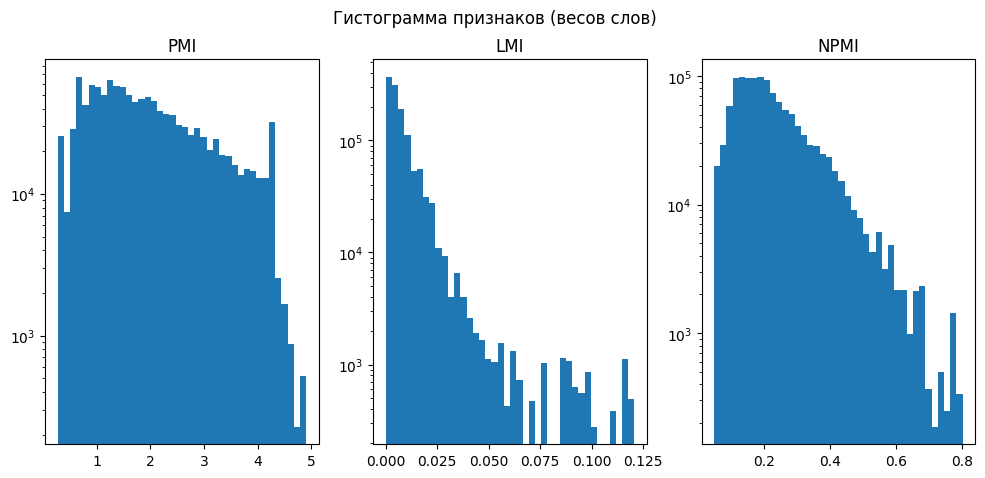

In [20]:
titles = ['PMI', 'LMI', 'NPMI']
plot_data = [pmi_train, lmi_train, npmi_train]
plot_weights(plot_data, titles)

## 3.3 Ранжирование токенов

In [21]:
label = 14
data = [matrix_pmi2, matrix_lmi2, matrix_npmi2]

print(f'Класс {target_names[label]}')
for matrix, title in zip(data, titles):
    print(title)
    top = pmi_doc.relevant_tokens_for_class(matrix, label)
    for element in top:
        print(element)

Класс sci.space
PMI
('vandalizing', 4.2539331610977715)
('leech', 4.2539331610977715)
('flyby', 4.2539331610977715)
('kjenks', 4.2539331610977715)
('orbiter', 4.2539331610977715)
('mohney', 4.2539331610977715)
('mahler', 4.2539331610977715)
('nsmca', 4.2539331610977715)
('dietz', 4.2539331610977715)
('c5t05k', 4.2539331610977715)
LMI
('space', 0.09097912078806633)
('nasa', 0.055867610087598024)
('orbit', 0.04901585155370534)
('moon', 0.03934236520928235)
('launch', 0.03502469998805174)
('earth', 0.03159718436158909)
('shuttle', 0.03063998017533294)
('prb', 0.028323390722256692)
('flight', 0.02537572477047886)
('spacecraft', 0.025064653278279003)
NPMI
('orbit', 0.6504389461008887)
('space', 0.6324721213046648)
('moon', 0.5846541940179523)
('prb', 0.5841674163466344)
('shuttle', 0.5779638282047151)
('launch', 0.5763344217281373)
('spacecraft', 0.5719881961430414)
('nsmca', 0.5497528542305882)
('nasa', 0.5448970679544293)
('lunar', 0.5416485274504776)


## 3.4 Отбор признаков

In [22]:
k = 1000
print(f'Количество отфильтрованных токенов. Топ={k}')
pmi_features = top_features(matrix_pmi2, k=k)
print('PMI:', len(pmi_features))

lmi_features = top_features(matrix_lmi2, k=k)
print('LMI:', len(lmi_features))

npmi_features = top_features(matrix_npmi2, k=k)
print('NPMI:', len(npmi_features))

pmi_train_trunc = pmi_train[:, pmi_features]
pmi_test_trunc = pmi_test[:, pmi_features]

lmi_train_trunc = lmi_train[:, lmi_features]
lmi_test_trunc = lmi_test[:, lmi_features]

npmi_train_trunc = npmi_train[:, npmi_features]
npmi_test_trunc = npmi_test[:, npmi_features]

Количество отфильтрованных токенов. Топ=1000
PMI: 17159
LMI: 13786
NPMI: 17565


## 3.5 Моделирование

In [23]:
# бейзлайн
tfidf = TfidfVectorizer()
X_train_basline = tfidf.fit_transform([' '.join(text) for text in train_tokenized])
X_test_basline = tfidf.transform([' '.join(text) for text in test_tokenized])

In [24]:
nb = MultinomialNB()

pipe_std = make_pipeline(StandardScaler(with_mean=False),
                         MultinomialNB())

pipe_norm = make_pipeline(Normalizer(),
                         MultinomialNB())

pipe_svd = make_pipeline(TruncatedSVD(n_components=200, random_state=RS),
                         Normalizer(),
                         MinMaxScaler(),
                         MultinomialNB())

In [25]:
df_results = pd.DataFrame(columns=['model', 'accuracy'])

models = [('nb', nb), 
          ('std', pipe_std), 
          ('norm', pipe_norm), 
          ('svd', pipe_svd)]

X_train_data = [('PMI', pmi_train), 
                ('LMI', lmi_train), 
                ('NPMI', npmi_train),
                ('TFIDF', X_train_basline),
                ('PMI_TOP', pmi_train_trunc),
                ('LMI_TOP', lmi_train_trunc),
                ('NPMI_TOP', npmi_train_trunc)]

X_test_data = [pmi_test, 
               lmi_test, 
               npmi_test, 
               X_test_basline,
               pmi_test_trunc,
               lmi_test_trunc,
               npmi_test_trunc]

for m_name, model in tqdm(models):
    for (x_name, train_data), test_data in zip(X_train_data, X_test_data):
        name = x_name + '_' + m_name
        model.fit(train_data, y_train)
        y_pred = model.predict(test_data)
        accuracy_test = accuracy_score(y_test, y_pred)
        df_tmp = pd.DataFrame(data=[(name, accuracy_test)], columns=['model', 'accuracy'])
        df_results = pd.concat([df_results, df_tmp])

100%|████████████████████████████████████████████| 4/4 [01:35<00:00, 23.96s/it]


In [26]:
df_results = df_results.sort_values('accuracy', ascending=False).reset_index(drop=True)
df_results.head(10)

,model,accuracy
0,PMI_norm,0.837361
1,PMI_nb,0.836166
2,NPMI_TOP_nb,0.835767
3,NPMI_TOP_norm,0.830324
4,NPMI_norm,0.830191
5,PMI_TOP_norm,0.829926
6,PMI_TOP_nb,0.828864
7,NPMI_nb,0.828067
8,TFIDF_nb,0.809612
9,TFIDF_norm,0.809612


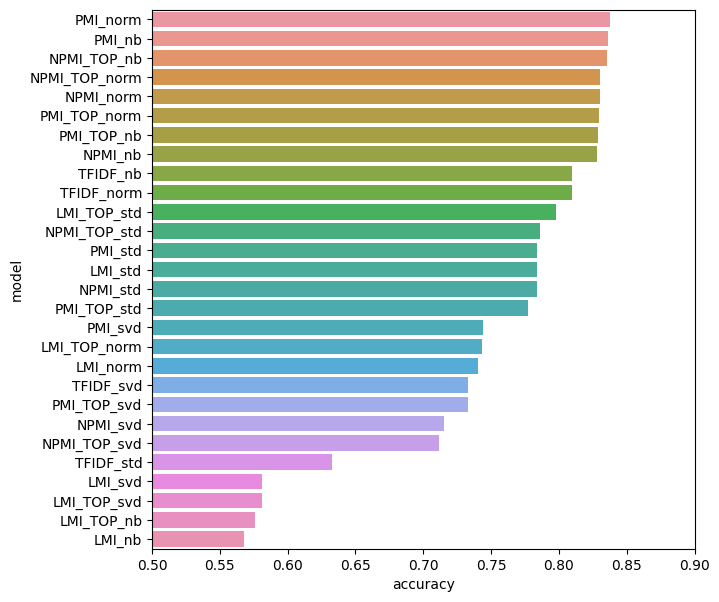

In [27]:
plt.figure(figsize=(7, 7))
sns.barplot(df_results, x='accuracy', y='model')
plt.xlim(0.5, .9);

+ Реализован подсчет PMI, LMI, NPMI через матричные операции;
+ PPMI помог избежать ошибок, связанных с отсутсвием токена в словаре или классе;
+ Для поиска релевантных пар (класс-токен) лучше подходят LMI, NPMI;
+ Реализована векторизация документов. Каждому токену присваивается максимальное значение PMI (LMI, NPMI) из всех классов;
+ Лучшая модель превосходит basline. При решение столкнулся с ошибкой, требующая для модели MultinomialNB неотрицательных значений (помог PPMI);